### Import Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("d4rklucif3r/cat-and-dogs")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cat-and-dogs


### Import Library

In [2]:
!pip install imbalanced-learn

In [3]:
import os
import numpy as np
import cv2
from skimage import io
from skimage.color import rgb2gray
import random
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
from imblearn.ensemble import BalancedRandomForestClassifier

np.random.seed(42)

IMAGE_SIZE = (128, 128)

### EDA

Total categories available: 2


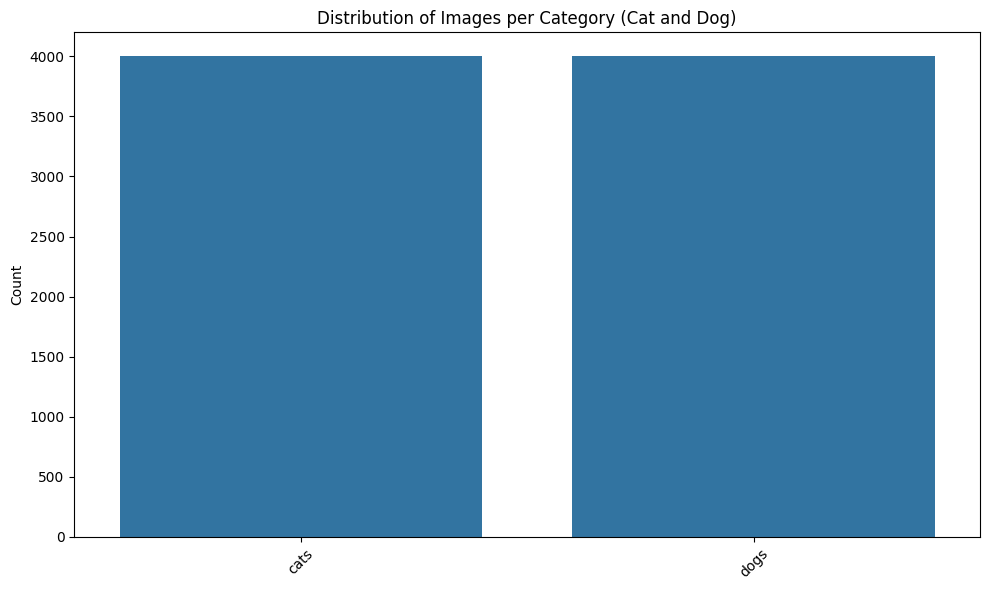


Selected 2 categories with sufficient samples:
['cats', 'dogs']


In [4]:
# Correct path to training set
dataset_path = "/kaggle/input/cat-and-dogs/dataset/training_set"  # Adjusted path

def load_and_analyze_dataset(path):
    categories = sorted(os.listdir(path))  # Categories: 'cats' and 'dogs'
    category_counts = {}
    print(f"Total categories available: {len(categories)}")

    for category in categories:
        category_path = os.path.join(path, category)
        count = len(os.listdir(category_path))  # Count images in each category
        category_counts[category] = count

    # Plotting the distribution of images per category
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
    plt.xticks(rotation=45)
    plt.title('Distribution of Images per Category (Cat and Dog)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    return category_counts

category_counts = load_and_analyze_dataset(dataset_path)

# Selecting categories with sufficient images (e.g., >= 120 images per category)
selected_categories = [category for category, count in category_counts.items() if count >= 120]
print(f"\nSelected {len(selected_categories)} categories with sufficient samples:")
print(selected_categories)


### Preprocessing

In [5]:
# Function to apply Gaussian and Median filters (Noise Reduction)
def apply_filters(image_path):
    # Load image
    image = io.imread(image_path)
    image_gray = rgb2gray(image)  # Convert to grayscale for better results

    # Apply Gaussian filter
    gaussian_filtered = cv2.GaussianBlur(image_gray, (5, 5), 0)

    # Apply Median filter
    median_filtered = cv2.medianBlur((image_gray * 255).astype(np.uint8), 5)

    return image_gray, gaussian_filtered, median_filtered

# Function for Contrast Stretching
def contrast_stretching(image):
    # Define the min and max pixel values for contrast stretching
    min_val = np.min(image)
    max_val = np.max(image)

    # Apply contrast stretching
    stretched_image = (image - min_val) * (255 / (max_val - min_val))
    return np.uint8(stretched_image)

# Function to apply Histogram Equalization and Contrast Stretching
def apply_image_enhancements(image_path):
    # Load image
    image = io.imread(image_path)
    image_gray = rgb2gray(image)  # Convert to grayscale for better results

    # Apply Histogram Equalization
    hist_eq_image = cv2.equalizeHist((image_gray * 255).astype(np.uint8))

    # Apply Contrast Stretching
    contrast_stretched_image = contrast_stretching(image_gray * 255)

    return image_gray, hist_eq_image, contrast_stretched_image

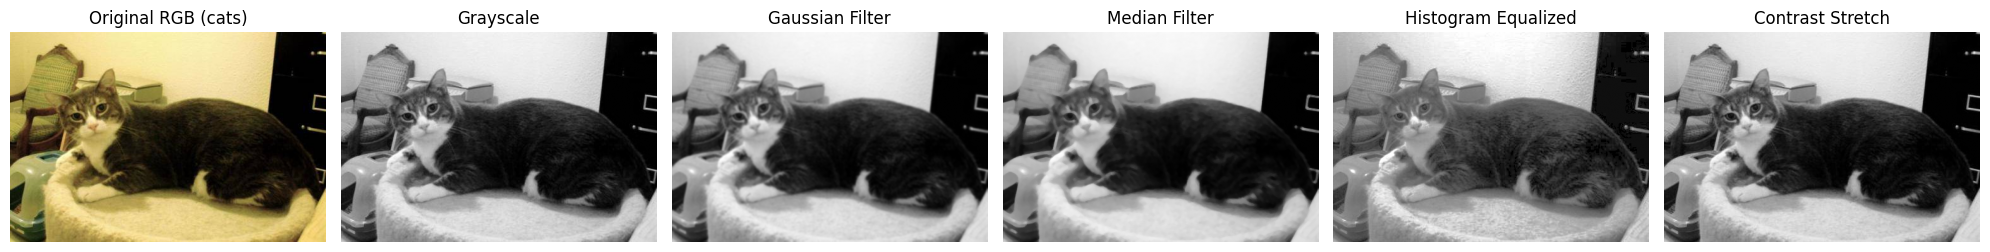

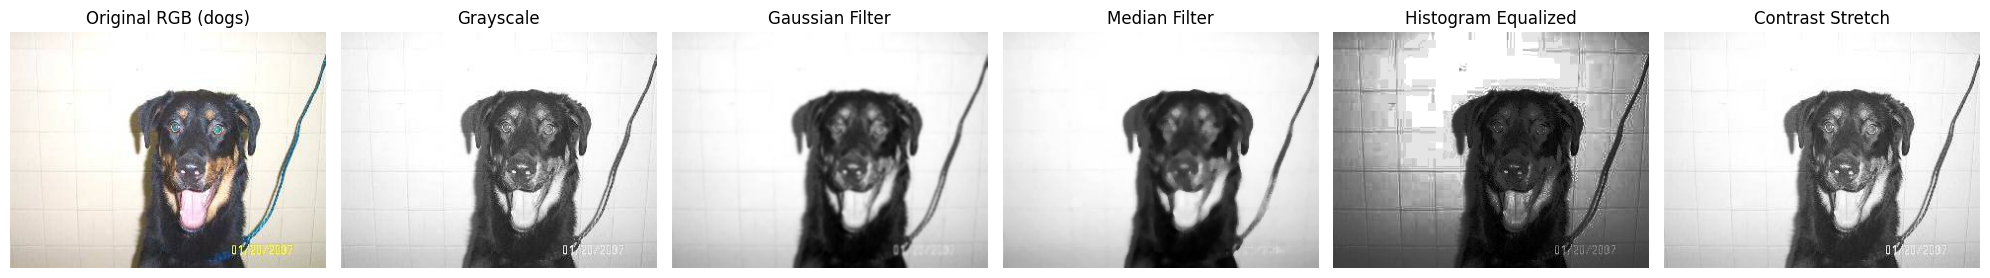

In [6]:
# Asumsikan `selected_categories` sudah didefinisikan dari analisis dataset
for category in selected_categories:
    category_path = os.path.join(dataset_path, category)
    image_files = os.listdir(category_path)

    if not image_files:
        print(f"No images found in {category_path}")
        continue

    image_path = os.path.join(category_path, image_files[0])
    img_rgb = cv2.imread(image_path)
    if img_rgb is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Apply filters
    grayscale_image, gaussian_filtered, median_filtered = apply_filters(image_path)

    # Apply enhancements
    _, hist_eq_image, contrast_stretched_image = apply_image_enhancements(image_path)

    # Plotting results
    fig, axes = plt.subplots(1, 6, figsize=(20, 6))

    axes[0].imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original RGB ({category})")
    axes[0].axis('off')

    axes[1].imshow(grayscale_image, cmap='gray')
    axes[1].set_title("Grayscale")
    axes[1].axis('off')

    axes[2].imshow(gaussian_filtered, cmap='gray')
    axes[2].set_title("Gaussian Filter")
    axes[2].axis('off')

    axes[3].imshow(median_filtered, cmap='gray')
    axes[3].set_title("Median Filter")
    axes[3].axis('off')

    axes[4].imshow(hist_eq_image, cmap='gray')
    axes[4].set_title("Histogram Equalized")
    axes[4].axis('off')

    axes[5].imshow(contrast_stretched_image, cmap='gray')
    axes[5].set_title("Contrast Stretch")
    axes[5].axis('off')

    plt.tight_layout()
    plt.show()


### Feature Extraction

In [7]:
def extract_enhanced_features(img_array):
    img = cv2.resize(img_array, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray, orientations=12, pixels_per_cell=(32, 32),
                       cells_per_block=(3, 3), feature_vector=True)
    lbp = local_binary_pattern(gray, 24, 3, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=256, range=(0, 256))
    lbp_hist = lbp_hist / (lbp_hist.sum() + 1e-6)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    color_features = []
    for i in range(3):
        channel = lab[:, :, i]
        color_features.extend([
            np.mean(channel),
            np.std(channel),
            np.median(channel),
            np.min(channel),
            np.max(channel)
        ])
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    texture_features = [
        np.mean(sobelx),
        np.std(sobelx),
        np.mean(sobely),
        np.std(sobely)
    ]
    return np.concatenate([hog_features, lbp_hist, color_features, texture_features])

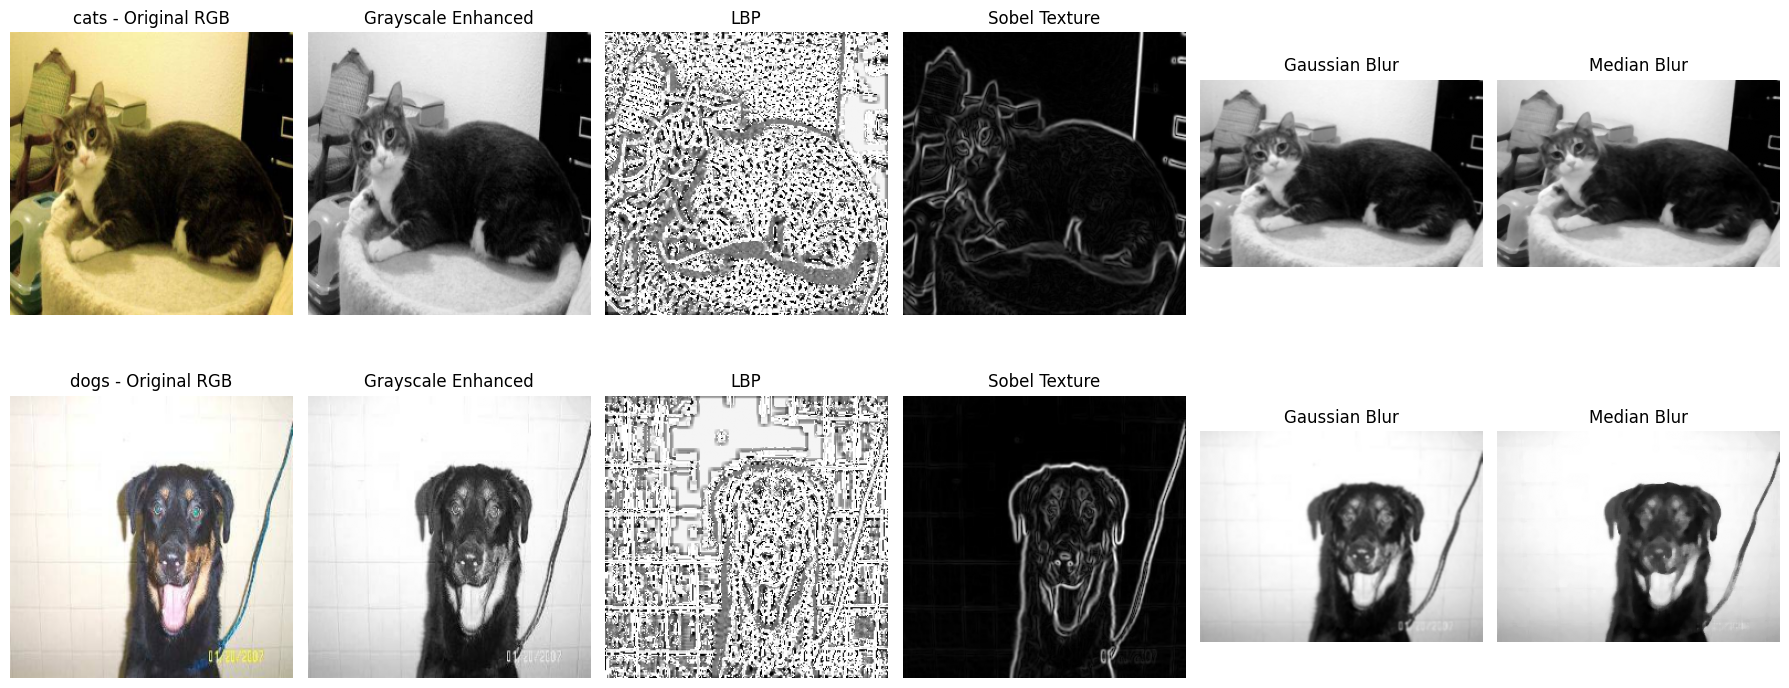

In [10]:
def visualize_feature_extract_all_categories(categories, dataset_path):
    num_categories = len(categories)
    fig, axs = plt.subplots(num_categories, 6, figsize=(18, 4 * num_categories))

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        image_files = os.listdir(category_path)
        if not image_files:
            print(f"[!] Tidak ada gambar di kategori: {category}")
            continue

        img_path = os.path.join(category_path, image_files[0])

        # Preprocessing - dari fungsi yang sudah kamu buat sebelumnya
        original_gray, gaussian_filtered, median_filtered = apply_filters(img_path)
        _, hist_eq_image, contrast_stretched_image = apply_image_enhancements(img_path)

        # Gunakan contrast_stretched_image untuk ekstraksi fitur
        gray_img = cv2.resize(contrast_stretched_image, (256, 256))

        # Ekstraksi fitur visual
        lbp = local_binary_pattern(gray_img, 24, 3, method='uniform')
        sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)
        sobel_combined = np.hypot(sobelx, sobely)

        # Load original RGB image untuk visualisasi
        img_rgb = io.imread(img_path)
        img_rgb = cv2.resize(img_rgb, (256, 256))

        # Plot hasil
        axs[i, 0].imshow(img_rgb)
        axs[i, 0].set_title(f"{category} - Original RGB")
        axs[i, 1].imshow(gray_img, cmap='gray')
        axs[i, 1].set_title("Grayscale Enhanced")
        axs[i, 2].imshow(lbp, cmap='gray')
        axs[i, 2].set_title("LBP")
        axs[i, 3].imshow(sobel_combined, cmap='gray')
        axs[i, 3].set_title("Sobel Texture")
        axs[i, 4].imshow(gaussian_filtered, cmap='gray')
        axs[i, 4].set_title("Gaussian Blur")
        axs[i, 5].imshow(median_filtered, cmap='gray')
        axs[i, 5].set_title("Median Blur")

        for j in range(6):
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()


# Panggil fungsi
visualize_feature_extract_all_categories(selected_categories, dataset_path)

### Data Augmentation

In [11]:
def manual_augmentation(img):
    augmented = [cv2.flip(img, 1)]
    rows, cols = img.shape[:2]
    for angle in [10, -10, 15, -15]:
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        augmented.append(cv2.warpAffine(img, M, (cols, rows)))
    for beta in [30, -30]:
        augmented.append(cv2.convertScaleAbs(img, beta=beta))
    return augmented

In [19]:
X, y = [], []
target_samples = 250

print("\nExtracting features with augmentation...")
for category in tqdm(selected_categories):
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)
    selected_images = images[:target_samples]

    for img_name in selected_images:
        img_path = os.path.join(category_path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            features = extract_enhanced_features(img)
            X.append(features)
            y.append(category)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

    # Jika jumlah gambar asli < target_samples, tambahkan augmented
    if len(images) < target_samples:
        num_to_augment = target_samples - len(images)
        for i in range(min(num_to_augment, len(images))):
            try:
                img_path = os.path.join(category_path, images[i])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                augmented_imgs = manual_augmentation(img)
                for aug_img in augmented_imgs[:min(3, num_to_augment)]:
                    features = extract_enhanced_features(aug_img)
                    X.append(features)
                    y.append(category)
            except Exception as e:
                print(f"Error augmenting {img_path}: {str(e)}")

X = np.array(X)
y = np.array(y)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nFinal dataset shape:", X.shape)
print("Class distribution:", Counter(y))



Extracting features with augmentation...


100%|██████████| 2/2 [00:23<00:00, 11.88s/it]


Final dataset shape: (500, 4163)
Class distribution: Counter({np.str_('cats'): 250, np.str_('dogs'): 250})


In [17]:
X = np.array(X)
y = np.array(y)

In [18]:
print("Fitur extraction done:", X.shape, y.shape)

Fitur extraction done: (500, 4163) (500,)


### Scalling fitur

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectFromModel(
    BalancedRandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median'
)
X_selected = selector.fit_transform(X_scaled, y_encoded)

X_final = X_selected

print(f"\nReduced feature dimensions: {X_final.shape[1]}")


Reduced feature dimensions: 2082


### Data Splitting

In [23]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_final, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

### Model Building

In [20]:
knn = KNeighborsClassifier(n_jobs=-1)

#### Model Parameter

In [21]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'cosine'],
    'p': [1, 2]  # Manhattan (p=1), Euclidean (p=2)
}

### HyperParameter Tuning

In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

knn_random_search = RandomizedSearchCV(knn, knn_param_grid, n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=3)

In [27]:
knn_random_search.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'chebyshev', 'cosine'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 13, 15,
                                                        17],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, verbose=3)

In [31]:
best_knn = knn_random_search.best_estimator_

### KNN after & before tuning

In [32]:
before_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean', n_jobs=-1)
before_knn.fit(X_train_full, y_train_full)

KNeighborsClassifier(metric='euclidean', n_jobs=-1)

In [33]:
after_knn = best_knn
after_knn.fit(X_train_full, y_train_full)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=7, p=1)

In [34]:
before_knn_pred = before_knn.predict(X_test)
after_knn_pred = after_knn.predict(X_test)

In [35]:
before_knn_acc = accuracy_score(y_test, before_knn_pred)
after_knn_acc = accuracy_score(y_test, after_knn_pred)

In [36]:
before_knn_labels = le.inverse_transform(y_test)
after_knn_labels = le.inverse_transform(y_test)

In [37]:
before_knn_pred_labels = le.inverse_transform(before_knn_pred)
after_knn_pred_labels = le.inverse_transform(after_knn_pred)

In [38]:
print(f"\nTest Accuracy (K-Neighbor Nearest Before Tuning): {before_knn_acc:.2%}")
print("Classification Report:")
print(classification_report(before_knn_labels, before_knn_pred_labels))


Test Accuracy (K-Neighbor Nearest Before Tuning): 71.00%
Classification Report:
              precision    recall  f1-score   support

        cats       0.86      0.50      0.63        50
        dogs       0.65      0.92      0.76        50

    accuracy                           0.71       100
   macro avg       0.75      0.71      0.70       100
weighted avg       0.75      0.71      0.70       100



In [39]:
print(f"\nTest Accuracy (K-Neighbor Nearest After Tuning): {after_knn_acc:.2%}")
print("Classification Report:")
print(classification_report(after_knn_labels, after_knn_pred_labels))


Test Accuracy (K-Neighbor Nearest After Tuning): 76.00%
Classification Report:
              precision    recall  f1-score   support

        cats       0.77      0.74      0.76        50
        dogs       0.75      0.78      0.76        50

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100



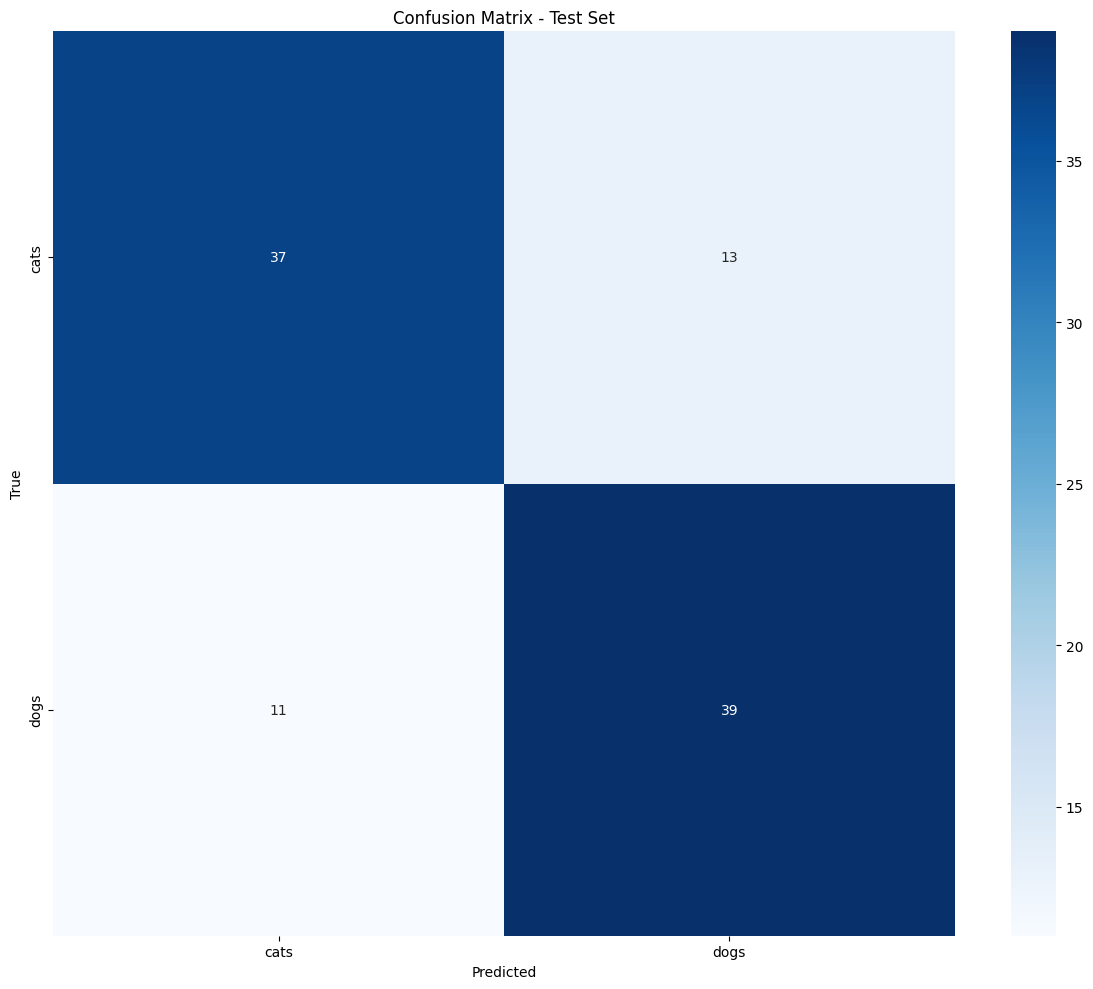

In [48]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [49]:
import joblib

joblib.dump({
    'model': ensemble,
    'scaler': scaler,
    'selector': selector,
    'label_encoder': le,
    'classes': selected_categories
}, 'cat_and_dog.pkl')

print("\nModel saved successfully!")



Model saved successfully!
